In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf

In [3]:
# Download historical data for all stocks in S&P 500
tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"].tolist()
data = yf.download(tickers, start='2015-01-01', end='2023-03-01', group_by='ticker')

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Use this cleaning if download from internet

In [5]:
#if download from internet
#Keeping only close price column
col_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
data.drop(col_drop, axis=1, level=1, inplace = True)
data.drop(['BRK.B', 'BF.B'], axis = 1, level=0, inplace = True ) #dropping missing values for 2 stocks
data = data.droplevel( level = 1, axis = 1)

creating correlation matrix and finding best pair for each stock

In [6]:
corr_matrix = data.corr()

In [8]:
most_cor_pairs = {} #pairs with highest positive corr for each stock
for ticker in corr_matrix:
    second_in_pair = corr_matrix[ticker].sort_values().index[-2]
    most_cor_pairs[ticker+'-'+second_in_pair]= data[[ticker,second_in_pair]]

In [9]:
for keys in most_cor_pairs:
    most_cor_pairs[keys] = most_cor_pairs[keys].rename(columns={most_cor_pairs[keys].columns[0]:'close_1',
                                       most_cor_pairs[keys].columns[1]:'close_2'})

In [10]:
results = {}
open_trades = {}

roll_window = 60
for pair_name, pair_data in most_cor_pairs.items():
    pair_data['spread'] = pair_data['close_1'] - pair_data['close_2']
    #spread_sigma = pair_data['spread'].std()
    spread_rolling = 1*pair_data['spread'].rolling(roll_window).std()
    pair_data['spread_zscore'] = (pair_data['spread'] - 
                                  pair_data['spread'].rolling(roll_window).mean()) / spread_rolling
    trades = []
    last_trades = []
    status = 0
    #if zscore > 1 : sell close 1, buy close 2
    #if zscore < -1 : buy close 1, sell close 2 
    for i in range(1, len(pair_data)):
        #open trade
        
        if pair_data.iloc[i-1]['spread_zscore'] > -1 and pair_data.iloc[i]['spread_zscore'] < -1 and status == 0:
            status = 1
            trade = {
                'direction': 'B/S',
                'open_time': pair_data.index[i],
                'open_price_1': pair_data.iloc[i]['close_1'],
                'open_price_2': pair_data.iloc[i]['close_2'],
                'spread_open': pair_data.iloc[i]['spread'],
                'spread_max': pair_data.iloc[i]['spread'],
                'spread_close': None,
                'close_price_1': None,
                'close_price_2': None,
                'close_time': None,
                'PnL': None,
                'tenor': None
            }
            
        #close trade
        elif pair_data.iloc[i-1]['spread_zscore'] < 0 and pair_data.iloc[i]['spread_zscore'] > 0 and status == 1:
            trade['spread_close'] = pair_data.iloc[i]['spread']
            trade['close_price_1'] = pair_data.iloc[i]['close_1']
            trade['close_price_2'] = pair_data.iloc[i]['close_2']
            trade['close_time'] = pair_data.index[i]
            trade['PnL'] = (((trade['close_price_1'] - trade['open_price_1']) / trade['open_price_1']) +
                            ((trade['open_price_2'] - trade['close_price_2']) / trade['open_price_2']))
            trade['tenor'] = trade['close_time'] - trade['open_time']
            trades.append(trade)
            status = 0
                #long 1 
        # long pnl : (final-initial)/initia
        #open trade
        if pair_data.iloc[i-1]['spread_zscore'] < 1 and pair_data.iloc[i]['spread_zscore'] > 1 and status == 0:
            status = 1
            trade = {
                'direction': 'S/B',
                'open_time': pair_data.index[i],
                'open_price_1': pair_data.iloc[i]['close_1'],
                'open_price_2': pair_data.iloc[i]['close_2'],
                'spread_open': pair_data.iloc[i]['spread'],
                'spread_max': pair_data.iloc[i]['spread'],
                'spread_close': None,
                'close_price_1': None,
                'close_price_2': None,
                'close_time': None,
                'PnL': None,
                'tenor': None
            }
            
        #close trade
        elif pair_data.iloc[i-1]['spread_zscore'] > 0 and pair_data.iloc[i]['spread_zscore'] < 0 and status == 1:
            trade['spread_close'] = pair_data.iloc[i]['spread']
            trade['close_price_1'] = pair_data.iloc[i]['close_1']
            trade['close_price_2'] = pair_data.iloc[i]['close_2']
            trade['close_time'] = pair_data.index[i]
            trade['PnL'] = (((trade['close_price_2'] - trade['open_price_2']) / trade['open_price_2']) +
                ((trade['open_price_1'] - trade['close_price_1']) / trade['open_price_1']))
            trade['tenor'] = trade['close_time'] - trade['open_time']
            trades.append(trade)
            status = 0
    results[pair_name] = pd.DataFrame(trades)
    last_trades.append(trade)
    open_trades[pair_name] = pd.DataFrame(last_trades)
            

In [11]:
summ = []
summary = {}
res = {}
for pair in results:
    if len(results[pair]) > 0:
        res = { 
            'pair': pair,
            'n_trades': len(results[pair]['PnL']),
            'average_pnl': results[pair]['PnL'].mean(),
            'min_pnl': results[pair]['PnL'].min(),
            'max_pnl': results[pair]['PnL'].max(),
            'sum_pnl': results[pair]['PnL'].sum(),
            'avg_yearly_return': results[pair]['PnL'].sum() / (2981/365)
            }
    summ.append(res)

In [12]:
summary = pd.DataFrame(summ)

In [13]:
sum_of_sum = {
    'total_n': summary['n_trades'].sum(),
    'avg_n': summary['n_trades'].mean(),
    'avg_pnl_for trade': summary['average_pnl'].mean(),
    'avg_yearyly_return' : summary['avg_yearly_return'].mean()
}

In [14]:
summary.sort_values('avg_yearly_return', ascending = False)[:20]

,pair,n_trades,average_pnl,min_pnl,max_pnl,sum_pnl,avg_yearly_return
206,AMD-POOL,62,0.068607,-0.276235,0.910424,4.253640,0.520825
387,MGM-FITB,79,0.048668,-0.091125,0.138965,3.844770,0.470762
398,QCOM-AMD,56,0.063987,-0.340932,0.780990,3.583262,0.438742
116,INCY-DISH,65,0.050843,-0.247469,0.338764,3.304803,0.404647
261,MHK-IVZ,50,0.058568,-0.222199,0.347289,2.928384,0.358558
482,ANET-ELV,64,0.044252,-0.325891,0.369442,2.832110,0.346770
81,AAL-CCL,64,0.042740,-0.341427,0.404950,2.735392,0.334927
425,MOH-AJG,64,0.041407,-0.564840,0.257198,2.650056,0.324478
281,ROL-HUM,67,0.038442,-0.167836,0.244012,2.575587,0.315360
101,LH-AMAT,64,0.040002,-0.247855,0.284821,2.560135,0.313468


<AxesSubplot:ylabel='Frequency'>

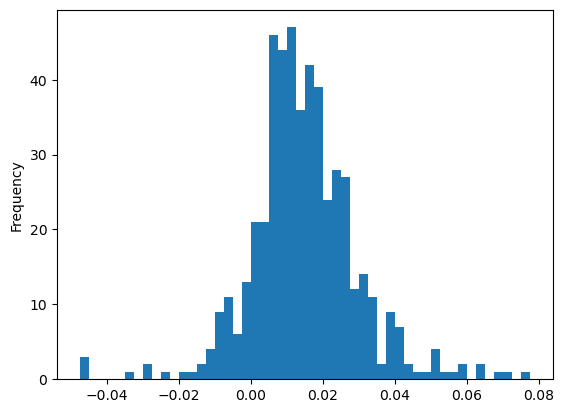

In [17]:
summary['average_pnl'].plot.hist(bins = 50)

In [18]:
sum_of_sum

{'total_n': 26552,
 'avg_n': 52.99800399201597,
 'avg_pnl_for trade': 0.014709254810280903,
 'avg_yearyly_return': 0.09696761009370862}